In [2]:
!pip install git+https://github.com/tensorflow/docs


  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-3b6wo71h
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-3b6wo71h
  Resolved https://github.com/tensorflow/docs to commit bbc0b9c70fc0bd4411793d1b0bcc56ef1dbc2405
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.11.18.43811-py3-none-any.whl size=182608 sha256=ff6f015436f6364157a388eed4836eebb5fe3abdf07f4c009d960f3b2525b947
  Stored in directory: /tmp/pip-ephem-wheel-cache-q3l28w4n/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
import keras
from keras import layers
from keras import ops
from tensorflow_docs.vis import embed
import tensorflow as tf
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [4]:
# Hiperparámetros
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128

In [5]:
# Importamos el dataset MNIST, que ya viene separado por X, y y train y test
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
all_clothes = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

# Al igual que hemos hecho otras veces, escalamos las imágenes entre 0 y 1
all_clothes = all_clothes.astype("float32") / 255.0
all_clothes = np.reshape(all_clothes, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Creamos el dataset y separamos en batches
dataset = tf.data.Dataset.from_tensor_slices((all_clothes, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_clothes.shape}")
print(f"Shape of training labels: {all_labels.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Shape of training images: (70000, 28, 28, 1)
Shape of training labels: (70000, 10)


In [6]:
# Hiperparámetros del modelo
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

In [7]:
# Creando el discriminador.
def build_discriminator():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(image_size, image_size, discriminator_in_channels)),
            keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"),
            keras.layers.LeakyReLU(0.2),
            keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"),
            keras.layers.LeakyReLU(0.2),
            keras.layers.Flatten(),
            keras.layers.Dense(1, activation="sigmoid"),
        ],
        name="discriminator",
    )
    return model
    discriminator = build_discriminator()

In [8]:
def build_generator():
    model = keras.Sequential(
        [
            keras.layers.InputLayer(input_shape=(generator_in_channels,)),
            keras.layers.Dense(7 * 7 * 128),
            keras.layers.Reshape((7, 7, 128)),
            keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"),
            keras.layers.LeakyReLU(0.2),
            keras.layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding="same"),
            keras.layers.LeakyReLU(0.2),
            keras.layers.Conv2D(num_channels, kernel_size=3, padding="same", activation="sigmoid"),
        ],
        name="generator",
    )
    return model

generator = build_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [9]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [11]:
   discriminator = build_discriminator()
   generator = build_generator()

In [12]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)

In [13]:
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

# Entrenamiento del modelo
epochs = 10
cond_gan.fit(dataset, epochs=epochs)

Epoch 1/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - d_loss: 0.6095 - g_loss: 0.8435
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - d_loss: 0.6595 - g_loss: 0.7567
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - d_loss: 0.6775 - g_loss: 0.7293
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - d_loss: 0.6809 - g_loss: 0.7245
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - d_loss: 0.6826 - g_loss: 0.7195
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - d_loss: 0.6840 - g_loss: 0.7205
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - d_loss: 0.6840 - g_loss: 0.7170
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - d_loss: 0.6858 - g_loss: 0.7148
Epoch 9/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - d_loss: 0.6866 - g_loss: 0.7131
Epoch 10/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - d_loss: 0.6874 - g_loss: 0.7124


In [14]:
# Etiquetas a generar. Modificar la lista labels como queramos
labels = [0,1,2,3,2,2,4,5,6,7,8,9]
n_samples = len(labels)

# Extraemos el generador de la CGAN
trained_gen = cond_gan.generator

# Convertimos las etiquetas en labels a categóricas
labels = keras.utils.to_categorical(labels, num_classes)

# Generamos el ruido para las diferentes imágenes a generar.
noise = keras.random.normal(shape=(n_samples, latent_dim))
noise = ops.reshape(noise, (n_samples, latent_dim))

# Concatenamos el ruido y las etiquetas para tener el input entero del generador
noise_and_labels = ops.concatenate([noise, labels], 1)

# Generamos las imágenes con el input
fake_images = trained_gen.predict(noise_and_labels)

# Convertimos a las dimensiones originales (28x28, aunque podríamos modificar los valores) y los valores de los píxeles yendo de 0 a 255 en vez de de 0 a 1
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step


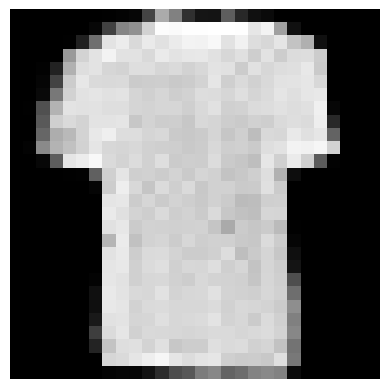

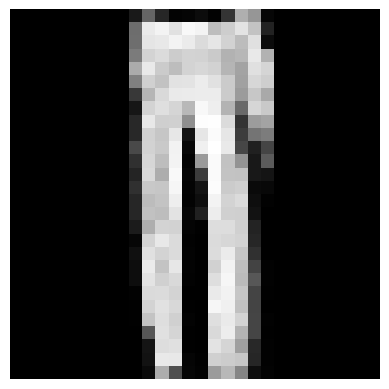

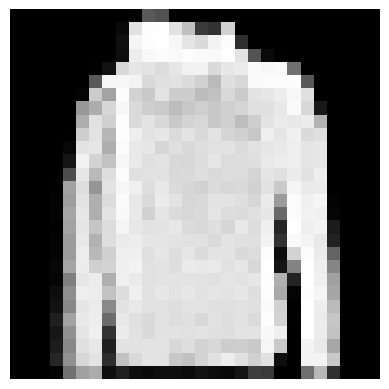

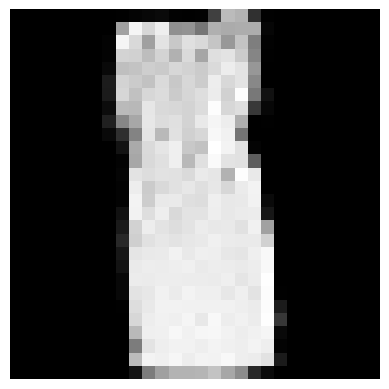

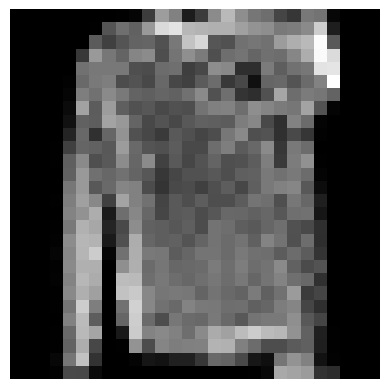

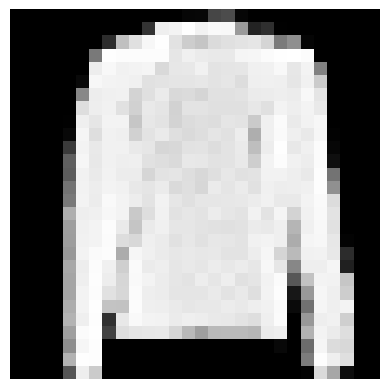

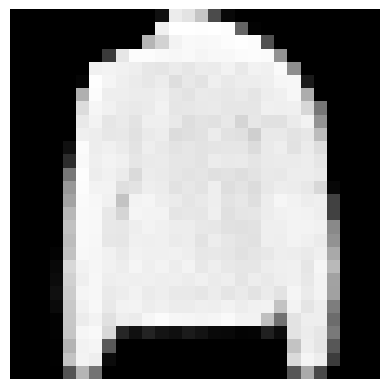

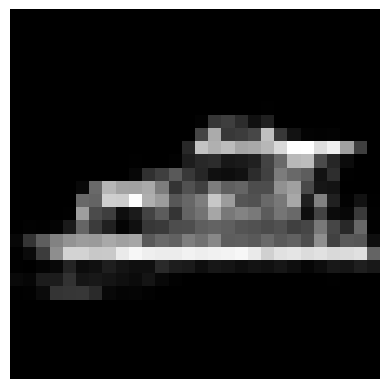

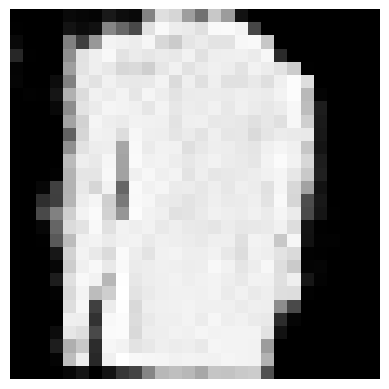

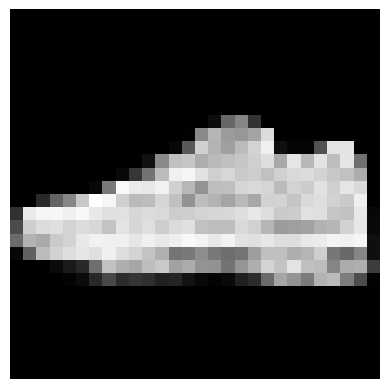

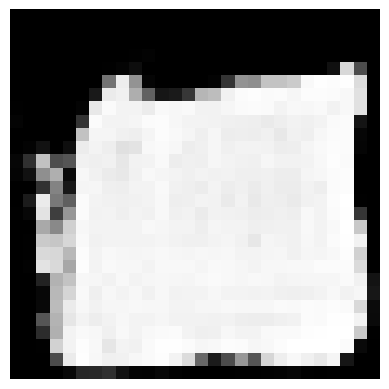

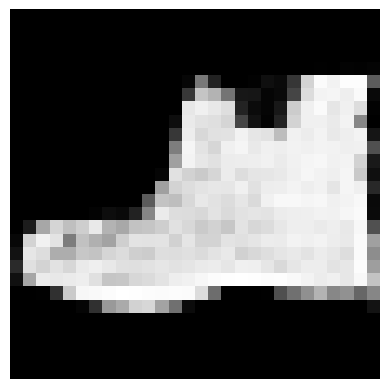

In [15]:
# Por último, mostramos las imágenes
for image in converted_images:
    plt.imshow(image[:,:,0], cmap='gray')
    plt.axis('off')
    plt.show()